In [23]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [24]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [30]:
import pymc as pm

print(f"Running on PyMC3 v{pm.__version__}")

# observational data
df=pd.DataFrame(columns=['vac','non_vac'])
df["vac"]=[27,7]
df["non_vac"]=[6,1]
df.index =["survive","dead"]
df

Running on PyMC3 v4.3.0


,vac,non_vac
survive,27,6
dead,7,1


In [ ]:
# define the model
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    p_vaccination = pm.Beta("p_vaccination",alpha=1,beta=1)
    p_dying_vaccinated= pm.Beta("p_dying_vaccinated",alpha=1,beta=1)
    p_dying_non_vaccinated= pm.Beta("p_dying_non_vaccinated",alpha=1,beta=1)

    # Obervational likelihoods
    vaccinated = pm.Binomial("vaccinated",n=df["vac"].sum(),p=p_vaccination,observed=df["vac"].sum())
    non_vaccinated = pm.Binomial("non_vaccinated",n=df["non_vac"].sum(),p=1-p_vaccination,observed=df["non_vac"].sum())
    dying_vaccinated = pm.Binomial("dying_vaccinated",n=vaccinated,p=p_dying_vaccinated,observed=df["vac"].loc["dead"])
    dying_non_vaccinated = pm.Binomial("dying_non_vaccinated",n=non_vaccinated,p=p_dying_non_vaccinated,observed=df["non_vac"].loc["dead"])

In [26]:

map_estimate = pm.find_MAP(model=basic_model)
map_estimate

{'p_vaccination_logodds__': array(1.5804497),
 'p_dying_vaccinated_logodds__': array(-1.34992502),
 'p_dying_non_vaccinated_logodds__': array(-1.79176394),
 'p_vaccination': array(0.8292682),
 'p_dying_vaccinated': array(0.20588263),
 'p_dying_non_vaccinated': array(0.1428566)}

In [27]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 10000 posterior samples
    slice_idata = pm.sample(10000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [p_vaccination]
>Slice: [p_dying_vaccinated]
>Slice: [p_dying_non_vaccinated]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 76 seconds.


,mean,sd,hdi_3%,hdi_97%
p_vaccination,0.814,0.058,0.706,0.920
p_dying_vaccinated,0.222,0.068,0.099,0.351
p_dying_non_vaccinated,0.223,0.133,0.013,0.465


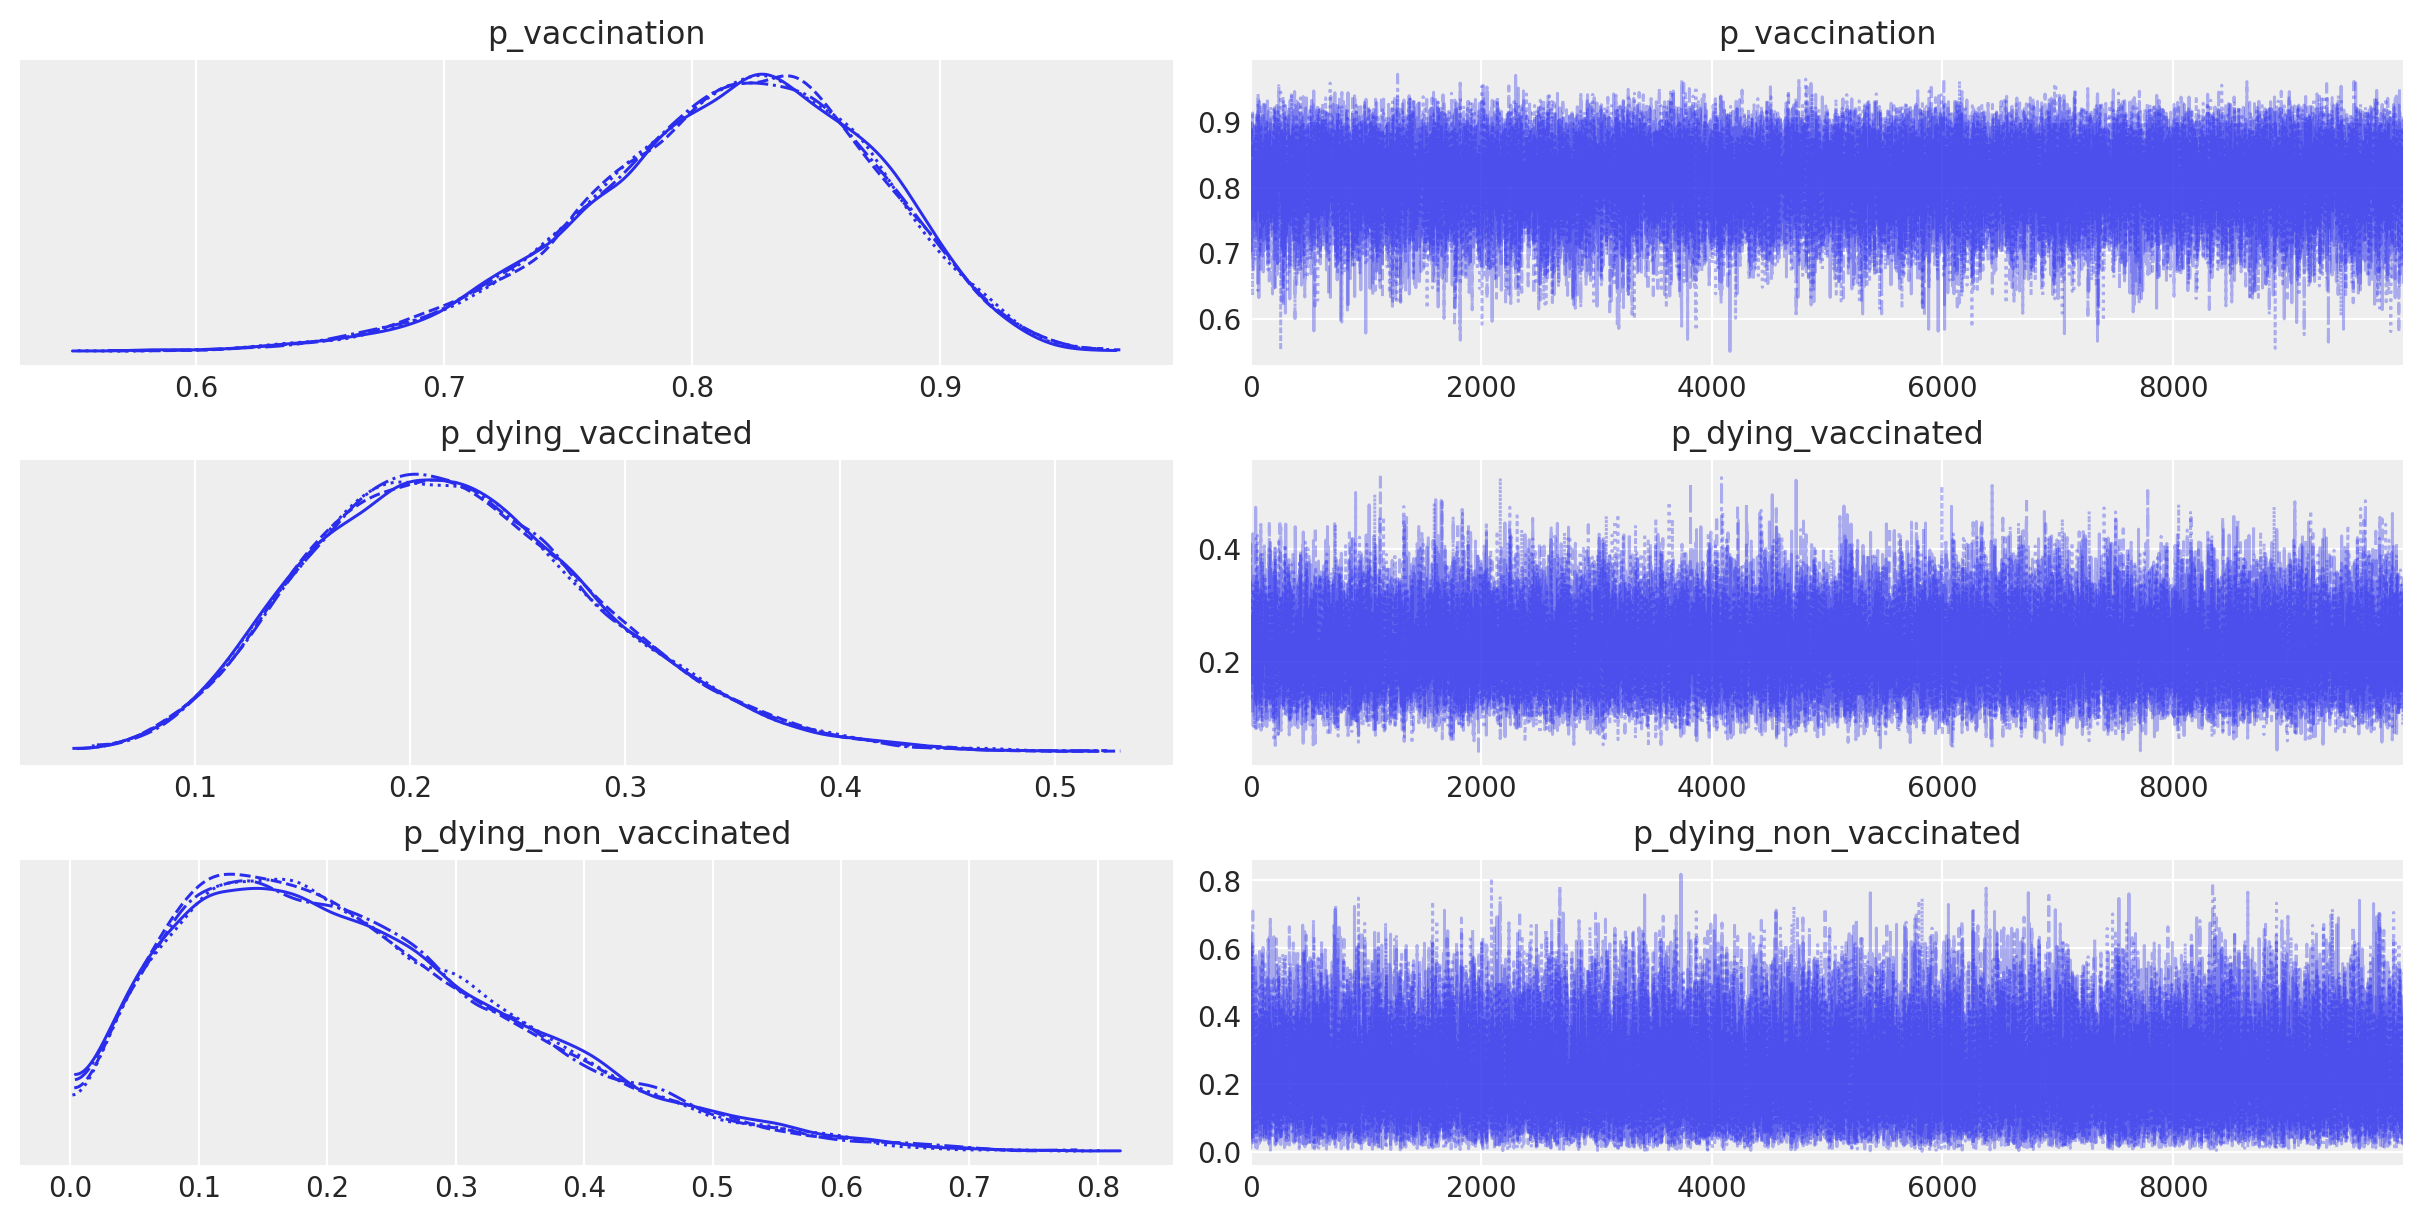

In [28]:
with basic_model:
    az.plot_trace(slice_idata);
az.summary(slice_idata, kind="stats")

### Important: p(I'm going to die) = E[p_dying_vaccinated] =  E[p_dying_non_vaccinated]
A collection of people gets vaxxed or not vaxxed and recieves a p_dying form the conditional distribution. The fraction of people dying will be 22% - no matter the vaxxination status.

In [29]:
with basic_model:
    # instantiate sampler
    p_dying_vaccinated_lower_p_dying_non_vaccinated = pm.Deterministic("p_dying_vaccinated<p_dying_non_vaccinated",p_dying_vaccinated<p_dying_non_vaccinated)
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(10000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [p_vaccination]
>Slice: [p_dying_vaccinated]
>Slice: [p_dying_non_vaccinated]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 61 seconds.


In [22]:
az.summary(slice_idata, kind="stats")

,mean,sd,hdi_3%,hdi_97%
p_vaccination,0.814,0.059,0.705,0.921
p_dying_vaccinated,0.221,0.068,0.098,0.348
p_dying_non_vaccinated,0.222,0.131,0.014,0.463
p_dying_vaccinated<p_dying_non_vaccinated,0.462,0.499,0.000,1.000


### Important: Pr[p_dying_vaccinated>p_dying_non_vaccinated] = 0.46
Its a coin-flip...